# Assignment 04 TorchCP

## Classification

### Basic Imports

In [1]:
import os
import time
import os.path as osp

from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets
from torchvision import transforms
import torchvision

from examples.common.dataset import build_dataset

from torchcp.classification.loss import ConfTr
from torchcp.classification.predictors import ClassWisePredictor,ClusterPredictor,SplitPredictor,WeightedPredictor
from torchcp.classification.scores import APS,Margin,RAPS,SAPS,THR
from torchcp.utils import fix_randomness

# plot
from pyecharts.charts import Bar
from pyecharts import options as opts
import matplotlib.pyplot as plt

### Hyperparameters

In [2]:
# # random seed
# SEED = 1 

# Testing
BATCH_SIZE = 256

# model 
OUTPUT_SIZE = 47 #101,43



### Device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Dataset

##### Food101

In [5]:
transform = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
train_dataset = torchvision.datasets.Food101(root='../data/', split="train",
                                       download=True, transform=transform)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

test_dataset = torchvision.datasets.Food101(root='../data/', split="test",
                                       download=True, transform=transform)

cal_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [12625, 12625])

cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [6]:
class_names = torchvision.datasets.Food101(root='../data/', split="test",download=True).classes
data_name = 'GTSRB'

##### GTSRB

In [4]:
transform = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.3416, 0.3119, 0.3232],[0.2738, 0.2633, 0.2729])
])
train_dataset = torchvision.datasets.GTSRB(root='../data/', split="train",
                                       download=True, transform=transform)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

test_dataset = torchvision.datasets.GTSRB(root='../data/', split="test",
                                       download=True, transform=transform)

cal_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [6315, 6315])

cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [ ]:
data_name = 'GTSRB'

##### DTD

In [40]:
transform = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5305, 0.4727, 0.4253],[0.2618, 0.2507, 0.2594])
])

train_dataset = torchvision.datasets.DTD(root='../data/', split="train",download=True, transform=transform)
val_dataset = torchvision.datasets.DTD(root='../data/', split="val", download=True, transform=transform)

train_dataset = train_dataset + val_dataset

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

test_dataset = torchvision.datasets.DTD(root='../data/', split="test",download=True, transform=transform)

cal_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [940, 940])

cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

In [44]:
data_name = 'DTD'

##### Get Mean-Std

In [36]:
def compute_channel_mean_std(train_dataloader):
    a=[]
    a.extend([[],[],[]])
    for data in train_dataloader:
        images,labels = data
        for i in range(images.size()[0]):
            for j in range(images.size()[1]):
                a[j].append(images[i][j].numpy().tolist())
    channel_means= torch.Tensor([np.mean(a[0]),np.mean(a[1]),np.mean(a[2])])
    channel_stddevs= torch.Tensor([np.std(a[0]),np.std(a[1]),np.std(a[2])])
    return channel_means, channel_stddevs

In [39]:
channel_means, channel_stddevs = compute_channel_mean_std(train_data_loader)
print("Channel means:", channel_means)
print("Channel standard deviations:", channel_stddevs)

Channel means: tensor([0.5305, 0.4727, 0.4253])
Channel standard deviations: tensor([0.2618, 0.2507, 0.2594])


In [35]:
# dir(torchvision.datasets)

### Model

##### ResNet-101

In [11]:
# Load the model RN101
model_RN101 = torchvision.models.resnet101(weights="IMAGENET1K_V1", progress=True)

for param in model_RN101.parameters():
    param.requires_grad = False
model_RN101.fc.requires_grad = True
model_RN101.fc = nn.Linear(fc_features,101)

##### ResNet-50

In [12]:
model_RN50 = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

for param in model_RN50.parameters():
    param.requires_grad = False
model_RN50.fc.requires_grad = True

fc_features = model_RN50.fc.in_features
model_RN50.fc = nn.Linear(fc_features,OUTPUT_SIZE)

In [13]:
model = model_RN50
# model = model_RN101
# model = LeNet()

model_name = 'ResNet50'
# model_name = 'LeNet'

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

##### Load Model

ResNet-50

In [15]:
path = "../model/ResNet50_GTSRB_checkpoint_15.pth"
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

### Training

In [12]:
def train(model, device,train_set, train_loader,criterion,  optimizer, epoch, NUM_EPOCHS):
    training_loss = []
    training_acc = []
    model.train()
    torch.cuda.empty_cache()
    
    running_cls_loss = 0.0
    running_cls_corrects = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        _, preds = torch.max(output, 1)
        
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)
        
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())
    
    return training_loss,training_acc

In [13]:
def test(model, device,test_set, test_loader,epoch, NUM_EPOCHS):
    model.eval()
    
    val_loss = 0.0
    val_corrects = 0
    for batch_idx, (data, target) in enumerate(test_data_loader):

        data,target = data.to(device),target.to(device)

        # test model
        outputs = model(data)
        loss = criterion(outputs, target)
        _, preds = torch.max(outputs, 1)

        val_loss += loss.item()
        val_corrects += torch.sum(preds == target.data)

    val_loss = val_loss / len(test_dataset)
    val_acc = val_corrects.double() / len(test_dataset)
    print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
    return val_loss,val_acc.cpu().detach().numpy()

In [14]:
# predictor = 
# criterion = ConfTr(weight=0.01,
#                         predictor=predictor,
#                         alpha=0.05,
#                         fraction=0.5,
#                         loss_type="valid",
#                         base_loss_fn=nn.CrossEntropyLoss())
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

In [1]:
NUM_EPOCHS = 3
for epoch in range(NUM_EPOCHS):
    loss,acc = train(model, device,train_dataset, train_data_loader, criterion, optimizer, epoch,NUM_EPOCHS)
    training_loss.append(loss)
    training_acc.append(acc)
    testloss,testacc = test(model,device,test_dataset, test_data_loader,epoch, NUM_EPOCHS)
    testing_loss.append(testloss)
    testing_acc.append(testacc)

In [26]:
# state = {
#     'state_dict': model.state_dict(),
#     'acc': training_acc,
#     'loss': training_loss,
#     'epoch': 5,
# }

# SAVE_DIR = "../model"
# # check the dir
# if not os.path.exists(SAVE_DIR):
#     os.makedirs(SAVE_DIR)

# # save the state
# torch.save(state, osp.join(SAVE_DIR, 'ResNet50_food101_checkpoint_5.pth'))

In [47]:
path = "../model/ResNet50_DTD_checkpoint_15.pth"
checkpoint = torch.load(path)

training_loss = checkpoint['train_loss']
training_acc = checkpoint['train_acc']
testing_loss = checkpoint['test_loss']
testing_acc = checkpoint['test_acc']

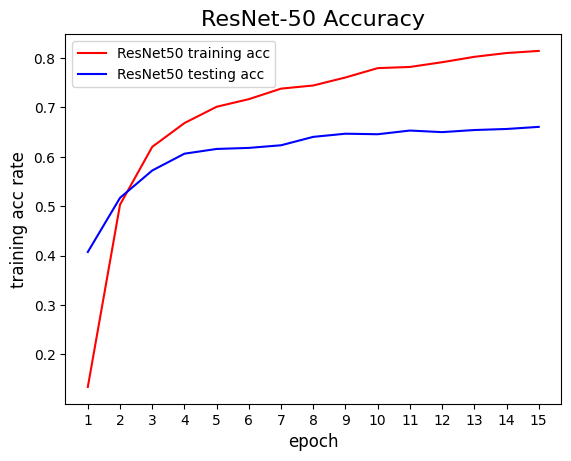

In [49]:
plt.figure()
plt.plot(list(range(1,16)),training_acc,color='r',label='ResNet50 training acc')
plt.plot(list(range(1,16)),testing_acc,color='b',label='ResNet50 testing acc')

plt.xticks(np.arange(1, 16, 1))

plt.title("ResNet-50 Accuracy",size=16)
plt.xlabel("epoch",size=12)
plt.ylabel("training acc rate",size=12)
plt.legend()
plt.savefig('./figure/ResNet50_DTD.png')
plt.show()

### TorchCP classification

In [25]:
# predictor = SplitPredictor(SAPS(0.2), model)
# predictor.calibrate(cal_data_loader, alpha)
# print(f"Experiment--Data : Food101, Model : {model_name}, Score : {SAPS(0.2).__class__.__name__}, Predictor : {predictor.__class__.__name__}, Alpha : {alpha}")
# result = predictor.evaluate(test_data_loader)
# print(result)

In [29]:
score_functions = [THR(),  APS(), RAPS(1, 0), SAPS(0.2)]

predictors = [SplitPredictor, ClassWisePredictor, ClusterPredictor]

alpha = 0.1

In [30]:
coverage_rate_list = []
average_size_list = []
score_list = []
predictor_list = []

for score in score_functions: 
    for class_predictor in predictors:
        predictor = class_predictor(score, model)
        predictor.calibrate(cal_data_loader, alpha)
        print(f"Experiment--Data : Food101, Model : {model_name}, Score : {score.__class__.__name__}, Predictor : {predictor.__class__.__name__}, Alpha : {alpha}")
        result = predictor.evaluate(test_data_loader)
        print(result)
        coverage_rate_list.append(result['Coverage_rate'])
        average_size_list.append(result['Average_size'])
        
        score_list.append(score.__class__.__name__)
        predictor_list.append(predictor.__class__.__name__)

Experiment--Data : Food101, Model : ResNet50, Score : THR, Predictor : SplitPredictor, Alpha : 0.1
{'Coverage_rate': 0.9016237623762376, 'Average_size': 7.489346534653466}
Experiment--Data : Food101, Model : ResNet50, Score : THR, Predictor : ClassWisePredictor, Alpha : 0.1
{'Coverage_rate': 0.8998019801980198, 'Average_size': 8.346059405940593}
Experiment--Data : Food101, Model : ResNet50, Score : THR, Predictor : ClusterPredictor, Alpha : 0.1
{'Coverage_rate': 0.9013069306930693, 'Average_size': 8.26930693069307}
Experiment--Data : Food101, Model : ResNet50, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
{'Coverage_rate': 0.9036039603960396, 'Average_size': 12.852514851485148}
Experiment--Data : Food101, Model : ResNet50, Score : APS, Predictor : ClassWisePredictor, Alpha : 0.1
{'Coverage_rate': 0.9061386138613862, 'Average_size': 13.21940594059406}
Experiment--Data : Food101, Model : ResNet50, Score : APS, Predictor : ClusterPredictor, Alpha : 0.1
{'Coverage_rate': 0.907168316

In [31]:
# state = {
#     "coverage_rate": coverage_rate_list,
#     "average_size": average_size_list,
#     "score":score_list,
#     "predictor":predictor_list,
# }

# SAVE_DIR = "../param"
# # check the dir
# if not os.path.exists(SAVE_DIR):
#     os.makedirs(SAVE_DIR)

# # save the state
# torch.save(state, osp.join(SAVE_DIR, 'ResNet50_food101.pth'))

In [63]:
# coverage_rate_list = []
# average_size_list = []
# score_list = []
# predictor_list = []

In [11]:
# path = "../param/ResNet50_food101.pth"
# checkpoint = torch.load(path)

# coverage_rate_list = checkpoint['coverage_rate']
# average_size_list = checkpoint['average_size']
# score_list = checkpoint['score']
# predictor_list = checkpoint['predictor']

### Plot

##### Load Data

In [50]:
path = "../param/ResNet50_DTD.pth"
checkpoint = torch.load(path)

coverage_rate_list = checkpoint['coverage_rate']
average_size_list = checkpoint['average_size']
score_list = checkpoint['score']
predictor_list = checkpoint['predictor']

In [52]:
from pyecharts.charts import Bar
from pyecharts import options as opts

def plot_bar(y,s,model_name,data_name):
    yy = []
    for i in y:
        yy.append(round(i,3))
    bar = (
        Bar()
        .add_xaxis(['SplitPredictor','ClassWisePredictor','ClusterPredictor'])
        # 这里需要注意 y轴上传递的只能是列表 不能是数组，如果是数组 数据无法显示
        .add_yaxis("THR",yy[0:3])  
        .add_yaxis("APS",yy[3:6])
        .add_yaxis("RAPS",yy[6:9])
        .add_yaxis("SAPS",yy[9:12])
        .set_global_opts(title_opts=opts.TitleOpts(title=f"{data_name} and {model_name}",subtitle=s))
        )

        # 在 jupyter notebook上输出
        # bar.render_notebook()
    bar.render(f'./figure/{data_name}_{model_name}_{s}.html')

In [53]:
# plot Average_size
plot_bar(average_size_list,"Average_size",'ResNet-50',data_name)

In [54]:
# plot Coverage_rate
plot_bar(coverage_rate_list,"Coverage_rate",'ResNet-50',data_name)

### Others

In [41]:
inputs, classes = next(iter(test_data_loader))
input = inputs[0:20,]
class20 = classes[0:20,]

In [45]:
def plot_dataset(data_name):
    plt.figure(figsize=(20, 5))
    for i in range(len(input)):
        image = input[i].numpy().transpose((1, 2, 0))
        plt.subplot(2, 10, i+1)
        plt.imshow((image),vmin=0, vmax=255)
        plt.xlabel(class20[i].item())
    plt.savefig(f'./figure/{data_name}.png')
    plt.show()

##### DTD

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

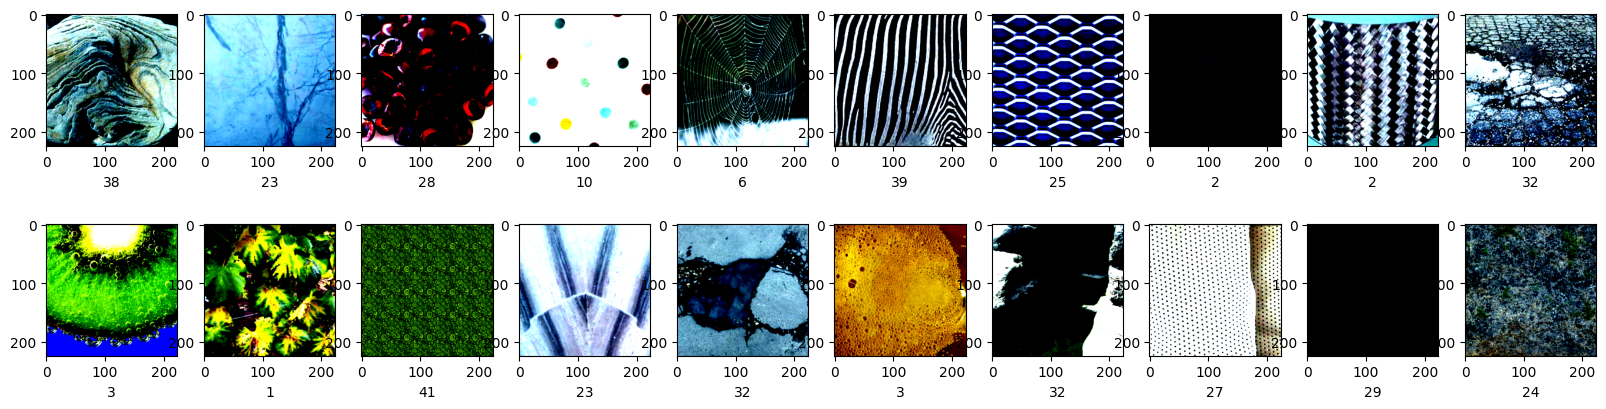

In [46]:
plot_dataset('DTD')

##### GTSRB

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

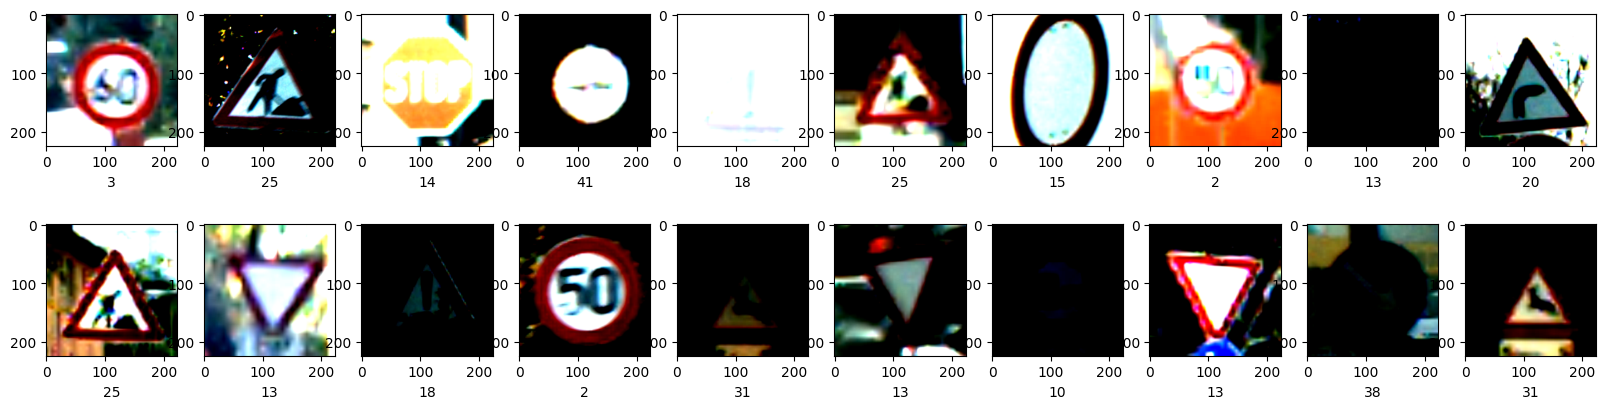

In [6]:
plt.figure(figsize=(20, 5))
for i in range(len(input)):
    image = input[i].numpy().transpose((1, 2, 0))
    plt.subplot(2, 10, i+1)
    plt.imshow((image),vmin=0, vmax=255)
#     plt.imshow((out * 255).astype(np.uint8))
#     plt.axis('off')
    plt.xlabel(class20[i].item())
plt.savefig('./figure/GTSRB.png')
plt.show()

##### Food-101

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

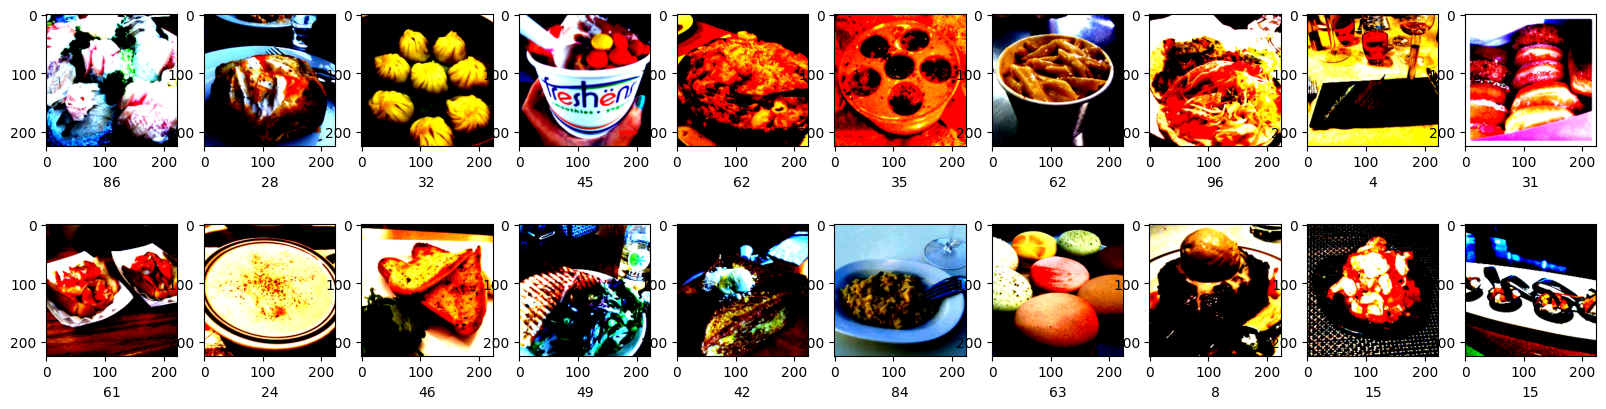

In [11]:
plt.figure(figsize=(20, 5))
for i in range(len(input)):
    image = input[i].numpy().transpose((1, 2, 0))
    plt.subplot(2, 10, i+1)
    plt.imshow((image),vmin=0, vmax=255)
#     plt.imshow((out * 255).astype(np.uint8))
#     plt.axis('off')
    plt.xlabel(class20[i].item())
plt.savefig('./figure/food101.png')
plt.show()